# Comparing ECCO an WOA datasets
for model validation

# <span style='color:Green'> ECCO

In [9]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
%matplotlib inline
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
import gsw

In [2]:
woa_8110 = xr.open_dataarray('/home/jovyan/WMT/WOA/ts_hist_8110.nc')
woa_0517 = xr.open_dataarray('/home/jovyan/WMT/WOA/ts_hist_0517.nc')
ecco = xr.open_dataarray('/home/jovyan/WMT/ECCO-budgets/ts_hist_mean_ECCO.nc')

# <span style='background :yellow'> Difference between ECCO and WOA (1981-2010) </span>

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


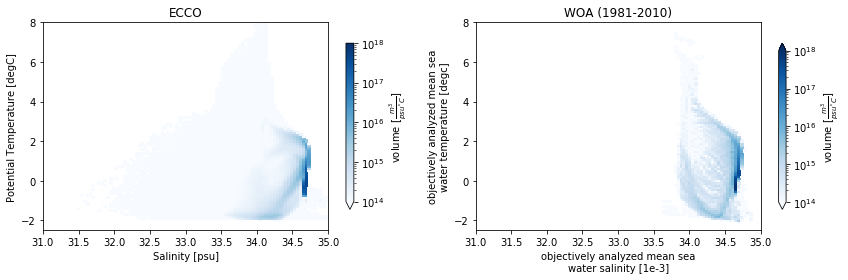

In [3]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

ecco.where(ecco>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e14, vmax=1e18,
                        cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'}, ax=ax0)
ax0.set_title('ECCO')

woa_8110.where(woa_8110>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e14, vmax=1e18,
                        cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'}, ax=ax1)
ax1.set_title('WOA (1981-2010)')

plt.tight_layout();

In [4]:
diff_ecco_woa8110 = ecco - woa_8110
diff_ecco_woa8110

<xarray.DataArray (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

In [5]:
xdim_salt = np.arange(31, 35, 0.1)
ydim_temp = np.arange(-2.5, 8, 0.1)

print(ydim_temp.shape, xdim_salt.shape)

(105,) (40,)


In [6]:
sigma = np.empty([40, 105])
for j in range(40):
    for i in range(105):
        sigma[j, i] = gsw.sigma2(xdim_salt[j], ydim_temp[i])

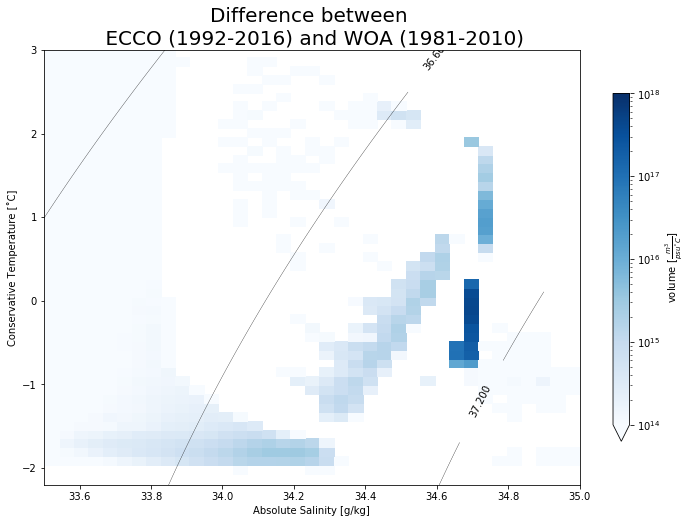

In [7]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

C = plt.contour(xdim_salt, ydim_temp, sigma.T, colors='k', linewidths=0.3)
plt.clabel(C)
diff_ecco_woa8110.where(diff_ecco_woa8110>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e14, vmax=1e18,
                                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Absolute Salinity [g/kg]')
ax.set_ylabel('Conservative Temperature [˚C]')
ax.set_title('Difference between \n ECCO (1992-2016) and WOA (1981-2010)', fontsize=20);
ax.set_xlim(33.5, 35)
ax.set_ylim(-2.2, 3);

## <span style='color:Purple'> Linear Scale

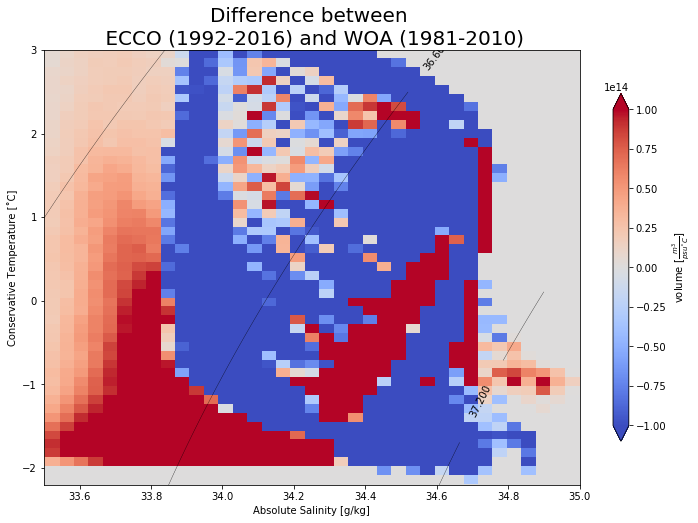

In [36]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

C = plt.contour(xdim_salt, ydim_temp, sigma.T, colors='k', linewidths=0.3)
plt.clabel(C)
diff_ecco_woa8110.plot(cmap='coolwarm', vmax=1e14,
                                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Absolute Salinity [g/kg]')
ax.set_ylabel('Conservative Temperature [˚C]')
ax.set_title('Difference between \n ECCO (1992-2016) and WOA (1981-2010)', fontsize=20);
ax.set_xlim(33.5, 35)
ax.set_ylim(-2.2, 3);

## <span style='color:Purple'> Semi-Log Scale
using `SymLogNorm()` --> have to specify `linthresh` parameter - below this absolute value the colormap is linear, and outside the ± bounds cmap is logarithmic.

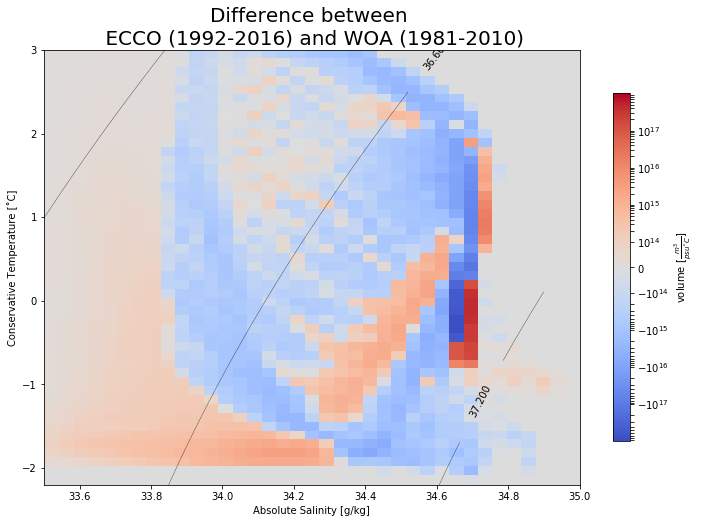

In [30]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

C = plt.contour(xdim_salt, ydim_temp, sigma.T, colors='k', linewidths=0.3)
plt.clabel(C)
diff_ecco_woa8110.plot(norm=SymLogNorm(linthresh=1e14), cmap='coolwarm', vmax=1e18,
                                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Absolute Salinity [g/kg]')
ax.set_ylabel('Conservative Temperature [˚C]')
ax.set_title('Difference between \n ECCO (1992-2016) and WOA (1981-2010)', fontsize=20);
ax.set_xlim(33.5, 35)
ax.set_ylim(-2.2, 3);

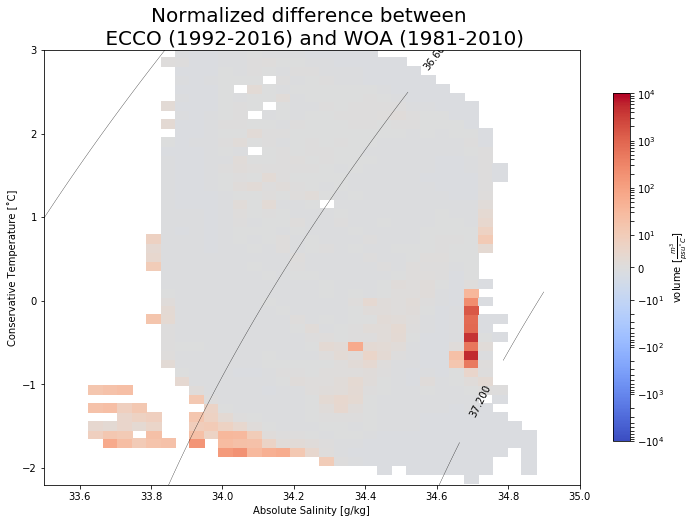

In [53]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

C = plt.contour(xdim_salt, ydim_temp, sigma.T, colors='k', linewidths=0.3)
plt.clabel(C)
(diff_ecco_woa8110/woa_8110).plot(norm=SymLogNorm(linthresh=10), cmap='coolwarm', vmax=1e4,
                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})
#got 0.4e18 from Linear Scale plot
#blue is positive
#red is negative

ax.set_xlabel('Absolute Salinity [g/kg]')
ax.set_ylabel('Conservative Temperature [˚C]')
ax.set_title('Normalized difference between \n ECCO (1992-2016) and WOA (1981-2010)', fontsize=20);
ax.set_xlim(33.5, 35)
ax.set_ylim(-2.2, 3);

# <span style='background :yellow'> Difference between ECCO and WOA (2005-2017)

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


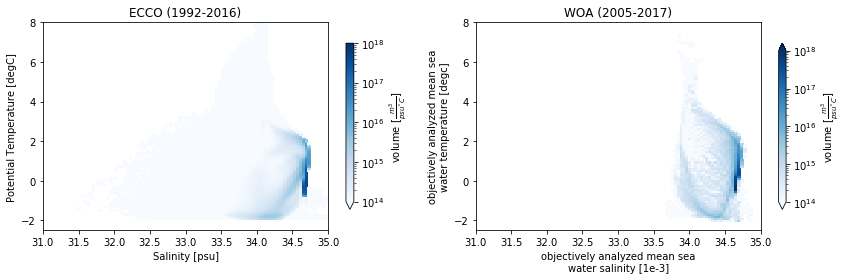

In [11]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

ecco.where(ecco>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e14, vmax=1e18,
                        cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'}, ax=ax0)
ax0.set_title('ECCO (1992-2016)')

woa_0517.where(woa_0517>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e14, vmax=1e18,
                        cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'}, ax=ax1)
ax1.set_title('WOA (2005-2017)')

plt.tight_layout();

In [12]:
diff_ecco_woa0517 = ecco - woa_0517
diff_ecco_woa0517

<xarray.DataArray (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

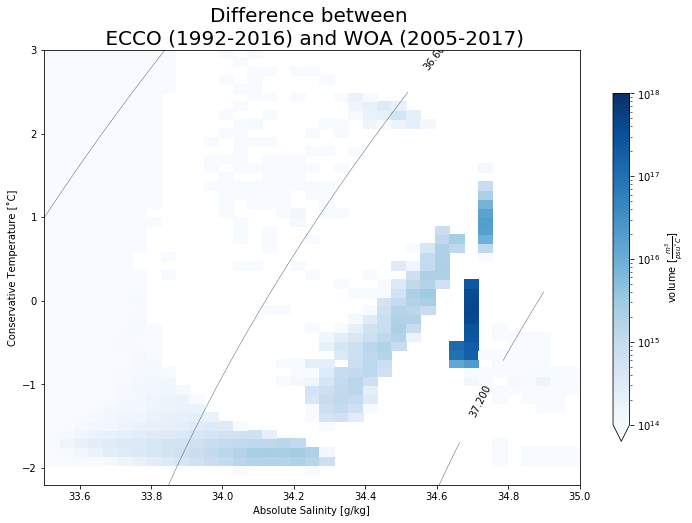

In [13]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

C = plt.contour(xdim_salt, ydim_temp, sigma.T, colors='k', linewidths=0.3)
plt.clabel(C)
diff_ecco_woa0517.where(diff_ecco_woa0517>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e14, vmax=1e18,
                                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Absolute Salinity [g/kg]')
ax.set_ylabel('Conservative Temperature [˚C]')
ax.set_title('Difference between \n ECCO (1992-2016) and WOA (2005-2017)', fontsize=20);
ax.set_xlim(33.5, 35)
ax.set_ylim(-2.2, 3);

## <span style='color:Purple'> Linear Scale

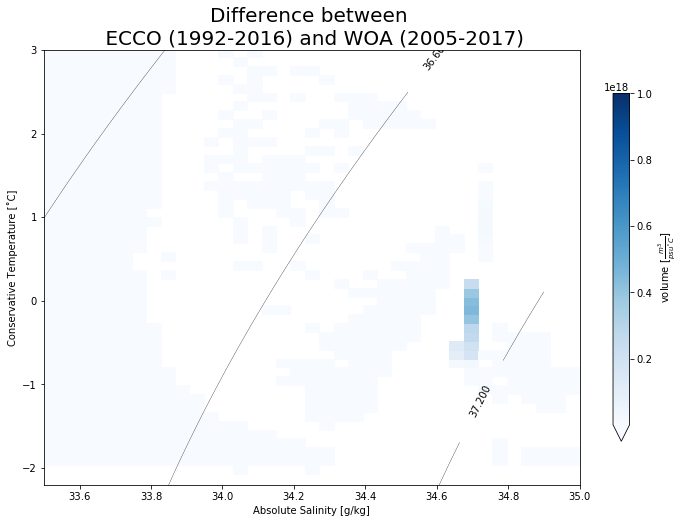

In [13]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

C = plt.contour(xdim_salt, ydim_temp, sigma.T, colors='k', linewidths=0.3)
plt.clabel(C)
diff_ecco_woa0517.plot(cmap='Blues', vmax=1e18, cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Absolute Salinity [g/kg]')
ax.set_ylabel('Conservative Temperature [˚C]')
ax.set_title('Difference between \n ECCO (1992-2016) and WOA (2005-2017)', fontsize=20);
ax.set_xlim(33.5, 35)
ax.set_ylim(-2.2, 3);

## <span style='color:Purple'> Semi-Log Scale
using `SymLogNorm()` --> have to specify `linthresh` parameter - below this absolute value the colormap is linear, and outside the ± bounds cmap is logarithmic.

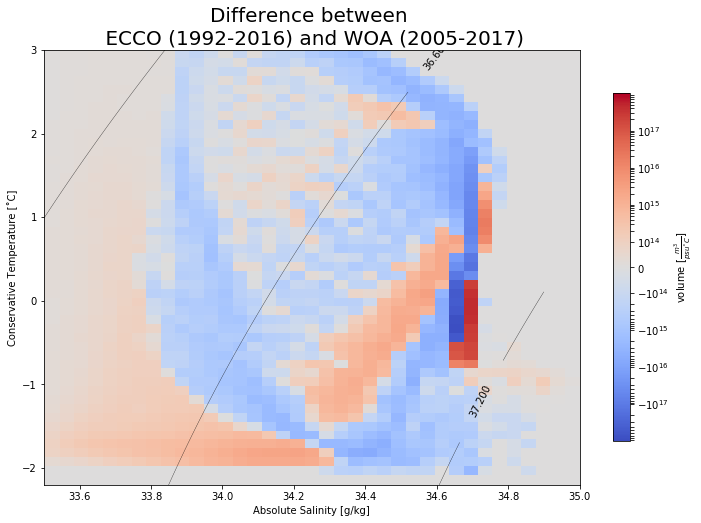

In [38]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

C = plt.contour(xdim_salt, ydim_temp, sigma.T, colors='k', linewidths=0.3)
plt.clabel(C)
diff_ecco_woa0517.plot(norm=SymLogNorm(linthresh=1e14), cmap='coolwarm', vmax=1e18,
                                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Absolute Salinity [g/kg]')
ax.set_ylabel('Conservative Temperature [˚C]')
ax.set_title('Difference between \n ECCO (1992-2016) and WOA (2005-2017)', fontsize=20);
ax.set_xlim(33.5, 35)
ax.set_ylim(-2.2, 3);

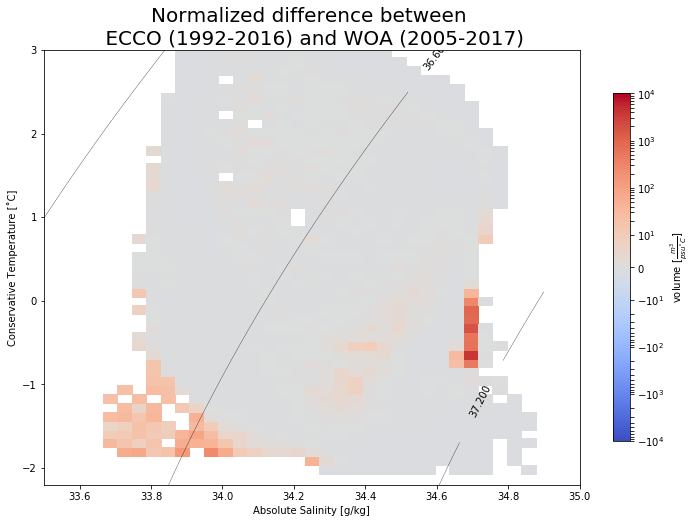

In [50]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

C = plt.contour(xdim_salt, ydim_temp, sigma.T, colors='k', linewidths=0.3)
plt.clabel(C)
(diff_ecco_woa0517/woa_0517).plot(norm=SymLogNorm(linthresh=10), cmap='coolwarm', vmax=1e4,
                                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Absolute Salinity [g/kg]')
ax.set_ylabel('Conservative Temperature [˚C]')
ax.set_title('Normalized difference between \n ECCO (1992-2016) and WOA (2005-2017)', fontsize=20);
ax.set_xlim(33.5, 35)
ax.set_ylim(-2.2, 3);